# UCSF-PDGM Dataset: ResNet18 Baseline Model

## Purpose
Implement a baseline binary classification model for brain tumor grading:
- **Architecture**: ResNet18 modified for 4-channel input
- **Input**: Mid-slice from T1, T1c, T2, FLAIR modalities (4-channel tensor)
- **Task**: Binary classification - Low grade (WHO 2, 3) vs High grade (WHO 4)
- **Goal**: Establish baseline performance metrics

## Model Modifications
- First convolutional layer: `Conv2d(3, 64, ...)` → `Conv2d(4, 64, ...)`
- Final fully connected layer: `Linear(512, 1000)` → `Linear(512, 1)` for binary classification
- Loss function: `BCEWithLogitsLoss` (numerically stable)

## Class Imbalance
The dataset has significant class imbalance (~8:1 ratio high:low grade).
We handle this using `WeightedRandomSampler` during training.

## 1. Setup & Configuration

In [34]:
import os
import re
from pathlib import Path
import random
import warnings

import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import models
import torchvision.transforms.functional as TF

from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score
)

warnings.filterwarnings('ignore')

print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.10.0+cu128


In [35]:
RANDOM_SEED = 42

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print(f"Random seed: {RANDOM_SEED}")

Random seed: 42


In [36]:
DATASET_PATH = Path("/content/Dataset/PKG - UCSF-PDGM Version 5/UCSF-PDGM-v5")
METADATA_CSV = "/content/Dataset/PKG - UCSF-PDGM Version 5/UCSF-PDGM-metadata_v5.csv"
MODALITIES = ["T1", "T1c", "T2", "FLAIR"]

BATCH_SIZE = 8
LEARNING_RATE = 1e-3
NUM_EPOCHS = 20
TRAIN_SPLIT = 0.8
IMG_SIZE = 224  # ResNet standard input size

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Configuration:")
print(f"  Dataset: {DATASET_PATH}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"  Device: {DEVICE}")

if torch.cuda.is_available():
    print(f"  GPU: {torch.cuda.get_device_name(0)}")

Configuration:
  Dataset: /content/Dataset/PKG - UCSF-PDGM Version 5/UCSF-PDGM-v5
  Batch size: 8
  Learning rate: 0.001
  Epochs: 20
  Image size: 224x224
  Device: cuda
  GPU: NVIDIA GeForce RTX 5070 Ti


## 2. Data Preparation Functions

In [37]:
def normalize_patient_id(pid):
    """
    Normalize patient ID to 4-digit format.
    Example: 'UCSF-PDGM-004' → 'UCSF-PDGM-0004'
    """
    match = re.search(r'UCSF-PDGM-(\d+)', str(pid))
    if match:
        number = int(match.group(1))
        return f"UCSF-PDGM-{number:04d}"
    return str(pid)

def find_modality_path(patient_id, modality, dataset_path=DATASET_PATH):
    """
    Find modality file path with fallback logic.
    """
    patient_folder = dataset_path / f"{patient_id}_nifti"
    
    if not patient_folder.exists():
        return None
    
    # Standard naming
    standard_path = patient_folder / f"{patient_id}_{modality}.nii.gz"
    if standard_path.exists():
        return standard_path
    
    # Bias-corrected version
    bias_path = patient_folder / f"{patient_id}_{modality}_bias.nii.gz"
    if bias_path.exists():
        return bias_path
    
    return None

def load_mid_slice(patient_id, modality, dataset_path=DATASET_PATH):
    """
    Load middle slice from a modality volume and apply z-score normalization.
    Returns normalized 2D numpy array.
    """
    path = find_modality_path(patient_id, modality, dataset_path)
    
    if path is None:
        return None
    
    try:
        # Load volume
        volume = nib.load(str(path)).get_fdata().astype(np.float32)
        
        # Extract middle slice
        z = volume.shape[2] // 2
        slice_2d = volume[:, :, z]
        
        # Z-score normalization on foreground (non-zero) voxels
        mask = slice_2d > 0
        if mask.any():
            mu = slice_2d[mask].mean()
            sd = slice_2d[mask].std() + 1e-6
            slice_2d = (slice_2d - mu) / sd
        
        return slice_2d
        
    except Exception as e:
        print(f"Error loading {path}: {e}")
        return None


## 3. Load & Prepare Metadata

In [38]:
# Load metadata
metadata = pd.read_csv(METADATA_CSV)

print(f"Total patients in metadata: {len(metadata)}")
print(f"\nFirst few rows:")
metadata.head()

Total patients in metadata: 501

First few rows:


,ID,Sex,Age at MRI,WHO CNS Grade,Final pathologic diagnosis (WHO 2021),MGMT status,MGMT index,1p/19q,IDH,1-dead 0-alive,OS,EOR,Biopsy prior to imaging,BraTS21 ID,BraTS21 Segmentation Cohort,BraTS21 MGMT Cohort
0,UCSF-PDGM-004,M,66,4,"Glioblastoma, IDH-wildtype",negative,0,unknown,wildtype,1,1303.0,STR,No,BraTS2021_00097,Training,Training
1,UCSF-PDGM-005,F,80,4,"Glioblastoma, IDH-wildtype",indeterminate,unknown,unknown,wildtype,1,274.0,biopsy,No,NaN,NaN,NaN
2,UCSF-PDGM-007,M,70,4,"Glioblastoma, IDH-wildtype",indeterminate,unknown,unknown,wildtype,1,417.0,STR,No,BraTS2021_00103,Training,NaN
3,UCSF-PDGM-008,M,70,4,"Glioblastoma, IDH-wildtype",negative,0,unknown,wildtype,1,185.0,STR,No,NaN,NaN,NaN
4,UCSF-PDGM-009,F,68,4,"Glioblastoma, IDH-wildtype",negative,0,unknown,wildtype,1,389.0,STR,No,BraTS2021_00049,Training,Training


In [39]:
# Ignored Samples as the are Reused Post-Op
IGNORED_PATIENT_IDS = ["UCSF-PDGM-0396_FU175d", "UCSF-PDGM-0409_FU001d", "UCSF-PDGM-0431_FU001d", "UCSF-PDGM-0391_FU016d", "UCSF-PDGM-0433_FU007d"]
metadata = metadata[~metadata.ID.isin(IGNORED_PATIENT_IDS)]

print(f"Updated total patients: {len(metadata)}")

Updated total patients: 496


In [40]:
# Create binary labels
# WHO Grade 2 → 0 (low grade)
# WHO Grade 3, 4 → 1 (high grade)

metadata['grade_binary'] = metadata['WHO CNS Grade'].apply(
    lambda x: 0 if x == 2 else (1 if x in [3, 4] else np.nan)
)

# Remove rows without binary label
metadata = metadata.dropna(subset=['grade_binary']).copy()
metadata['grade_binary'] = metadata['grade_binary'].astype(int)

print(f"Patients with binary labels: {len(metadata)}")
print(f"\nGrade distribution:")
print(metadata['grade_binary'].value_counts().sort_index())
print(f"\n  Low grade (0): {(metadata['grade_binary'] == 0).sum()}")
print(f"  High grade (1): {(metadata['grade_binary'] == 1).sum()}")

Patients with binary labels: 496

Grade distribution:
grade_binary
0     56
1    440
Name: count, dtype: int64

  Low grade (0): 56
  High grade (1): 440


In [41]:
# Normalize patient IDs
metadata['patient_id'] = metadata['ID'].apply(normalize_patient_id)

print("Sample normalized patient IDs:")
print(metadata[['ID', 'patient_id']].head())

Sample normalized patient IDs:
              ID      patient_id
0  UCSF-PDGM-004  UCSF-PDGM-0004
1  UCSF-PDGM-005  UCSF-PDGM-0005
2  UCSF-PDGM-007  UCSF-PDGM-0007
3  UCSF-PDGM-008  UCSF-PDGM-0008
4  UCSF-PDGM-009  UCSF-PDGM-0009


In [42]:
# Filter for complete cases (all 4 modalities present)
complete_patients = []

for idx, row in tqdm(metadata.iterrows(), total=len(metadata), desc="Checking files"):
    pid = row['patient_id']
    label = int(row['grade_binary'])
    
    # Check all modalities
    all_present = all(
        find_modality_path(pid, mod) is not None 
        for mod in MODALITIES
    )
    
    if all_present:
        complete_patients.append({
            'patient_id': pid,
            'label': label
        })

patient_df = pd.DataFrame(complete_patients)

print(f"\nComplete patients (all modalities present): {len(patient_df)}")
print(f"\nClass distribution in complete set:")
print(patient_df['label'].value_counts().sort_index())

Checking files: 100%|██████████| 496/496 [00:00<00:00, 12633.22it/s]


Complete patients (all modalities present): 496

Class distribution in complete set:
label
0     56
1    440
Name: count, dtype: int64


## 4. Train/Validation Split

In [43]:
# Split data at patient level (80/20)
patient_df = patient_df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
n_train = int(TRAIN_SPLIT * len(patient_df))

train_df = patient_df.iloc[:n_train].reset_index(drop=True)
val_df = patient_df.iloc[n_train:].reset_index(drop=True)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"\nTrain class distribution:")
print(train_df['label'].value_counts().sort_index())
print(f"\nValidation class distribution:")
print(val_df['label'].value_counts().sort_index())

Training samples: 396
Validation samples: 100

Train class distribution:
label
0     46
1    350
Name: count, dtype: int64

Validation class distribution:
label
0    10
1    90
Name: count, dtype: int64


## 5. Data Augmentation Function

In [44]:
def augment_4channel(image_tensor, augment=True):
    """
    Apply geometric augmentations to 4-channel image.
    
    Args:
        image_tensor: (4, H, W) float32 tensor
        augment: Whether to apply augmentation
    
    Returns:
        Augmented tensor
    """
    if not augment:
        return image_tensor
    
    # Random horizontal flip
    if random.random() < 0.5:
        image_tensor = TF.hflip(image_tensor)
    
    # Random vertical flip
    if random.random() < 0.5:
        image_tensor = TF.vflip(image_tensor)
    
    # Random rotation (-15 to +15 degrees)
    if random.random() < 0.5:
        angle = random.uniform(-15, 15)
        image_tensor = TF.rotate(
            image_tensor, angle, 
            interpolation=TF.InterpolationMode.BILINEAR
        )
    
    # Random affine (translation + scale)
    if random.random() < 0.5:
        translate = (random.randint(-10, 10), random.randint(-10, 10))
        scale = random.uniform(0.9, 1.1)
        image_tensor = TF.affine(
            image_tensor,
            angle=0,
            translate=translate,
            scale=scale,
            shear=[0, 0],
            interpolation=TF.InterpolationMode.BILINEAR
        )
    
    # Mild Gaussian noise
    if random.random() < 0.3:
        noise = torch.randn_like(image_tensor) * 0.02
        image_tensor = image_tensor + noise
    
    return image_tensor

## 6. Custom Dataset Class

In [45]:
class BrainTumorDataset(Dataset):
    """
    Custom dataset for UCSF-PDGM brain tumor classification.
    Loads 4-channel mid-slice for each patient.
    """
    
    def __init__(self, dataframe, dataset_path, modalities, 
                 img_size=224, augment=False):
        """
        Args:
            dataframe: pd.DataFrame with columns ['patient_id', 'label']
            dataset_path: Path to dataset root
            modalities: List of modality names
            img_size: Target image size (will resize to this)
            augment: Whether to apply data augmentation
        """
        self.df = dataframe.reset_index(drop=True)
        self.dataset_path = dataset_path
        self.modalities = modalities
        self.img_size = img_size
        self.augment = augment
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # Get patient info
        patient_id = self.df.loc[idx, 'patient_id']
        label = self.df.loc[idx, 'label']
        
        # Load all modalities
        channels = []
        for mod in self.modalities:
            slice_2d = load_mid_slice(patient_id, mod, self.dataset_path)
            
            if slice_2d is None:
                # Fallback: zeros
                slice_2d = np.zeros((256, 256), dtype=np.float32)
            
            channels.append(slice_2d)
        
        # Stack to (4, H, W)
        image = np.stack(channels, axis=0).astype(np.float32)
        
        # Convert to tensor
        image = torch.from_numpy(image)
        
        # Resize to target size
        image = image.unsqueeze(0)  # (1, 4, H, W)
        image = F.interpolate(
            image, 
            size=(self.img_size, self.img_size), 
            mode='bilinear', 
            align_corners=False
        )
        image = image.squeeze(0)  # (4, H, W)
        
        # Apply augmentation
        if self.augment:
            image = augment_4channel(image, augment=True)
        
        # Label as float for BCEWithLogitsLoss
        label = torch.tensor(label, dtype=torch.float32)
        
        return image, label

## 7. Create Data Loaders

In [47]:
# Instantiate datasets
train_dataset = BrainTumorDataset(
    train_df, 
    DATASET_PATH, 
    MODALITIES,
    img_size=IMG_SIZE,
    augment=True
)

val_dataset = BrainTumorDataset(
    val_df,
    DATASET_PATH,
    MODALITIES,
    img_size=IMG_SIZE,
    augment=False
)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Train dataset size: 396
Validation dataset size: 100


In [ ]:
# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=8,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=8,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

Training batches: 50
Validation batches: 13


## 8. Model Architecture

In [50]:
def create_resnet18_4channel(num_classes=1, pretrained=False):
    """
    Create ResNet18 modified for 4-channel input.
    
    Args:
        num_classes: Output dimension (1 for binary with BCEWithLogitsLoss)
        pretrained: Whether to use ImageNet weights (will ignore for conv1)
    
    Returns:
        Modified ResNet18 model
    """
    # Load base ResNet18
    if pretrained:
        model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    else:
        model = models.resnet18(weights=None)
    
    # Modify first convolutional layer: 3 channels → 4 channels
    model.conv1 = nn.Conv2d(
        in_channels=4,
        out_channels=64,
        kernel_size=7,
        stride=2,
        padding=3,
        bias=False
    )
    
    # Modify final fully connected layer for binary classification
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    
    return model


In [51]:
# Instantiate model
model = create_resnet18_4channel(num_classes=1, pretrained=False)
model = model.to(DEVICE)

# Print model summary
print(f"Model architecture:")
print(f"  First conv layer: {model.conv1}")
print(f"  Final FC layer: {model.fc}")
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Model architecture:
  First conv layer: Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  Final FC layer: Linear(in_features=512, out_features=1, bias=True)

Total parameters: 11,180,161
Trainable parameters: 11,180,161


## 9. Training Setup

In [52]:
# Loss function: Binary Cross Entropy with Logits
criterion = nn.BCEWithLogitsLoss()

# Optimizer: AdamW with weight decay
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=1e-4
)

# Learning rate scheduler: ReduceLROnPlateau
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',  # Monitor validation accuracy
    factor=0.5,
    patience=3,
    # verbose=True
)

print("Training setup complete:")
print(f"  Loss: {criterion}")
print(f"  Optimizer: AdamW")
print(f"  Scheduler: ReduceLROnPlateau")

Training setup complete:
  Loss: BCEWithLogitsLoss()
  Optimizer: AdamW
  Scheduler: ReduceLROnPlateau


In [53]:
# Training function
def train_one_epoch(model, loader, criterion, optimizer, device):
    """
    Train for one epoch.
    Returns average loss and accuracy.
    """
    model.train()
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc="Training")
    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        logits = model(images).squeeze(1)  # (B,)
        loss = criterion(logits, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Metrics
        running_loss += loss.item() * images.size(0)
        probs = torch.sigmoid(logits)
        preds = (probs >= 0.5).long()
        correct += (preds == labels.long()).sum().item()
        total += images.size(0)
        
        # Update progress bar
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{correct/total:.3f}'
        })
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    """
    Evaluate on validation set.
    Returns loss, accuracy, predictions, labels, and probabilities.
    """
    model.eval()
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    all_preds = []
    all_labels = []
    all_probs = []
    
    pbar = tqdm(loader, desc="Validation")
    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        logits = model(images).squeeze(1)
        loss = criterion(logits, labels)
        
        # Metrics
        running_loss += loss.item() * images.size(0)
        probs = torch.sigmoid(logits)
        preds = (probs >= 0.5).long()
        correct += (preds == labels.long()).sum().item()
        total += images.size(0)
        
        # Store for confusion matrix
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.long().cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        
        # Update progress bar
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{correct/total:.3f}'
        })
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc, np.array(all_preds), np.array(all_labels), np.array(all_probs)

## 10. Training Loop

In [54]:
# Track metrics
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0.0
best_model_state = None

print(f"Starting training for {NUM_EPOCHS} epochs...")
print("="*70)

# Execute training
for epoch in range(1, NUM_EPOCHS + 1):
    print(f"\nEpoch {epoch}/{NUM_EPOCHS}")
    print("-"*70)
    
    # Train
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, DEVICE
    )
    
    # Validate
    val_loss, val_acc, _, _, _ = evaluate(
        model, val_loader, criterion, DEVICE
    )
    
    # Update scheduler
    scheduler.step(val_acc)
    
    # Record metrics
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Print summary
    print(f"\nEpoch {epoch} Summary:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        print(f"  >>> New best validation accuracy: {best_val_acc:.4f}")

print("\n" + "="*70)
print(f"Training complete! Best validation accuracy: {best_val_acc:.4f}")

Starting training for 20 epochs...

Epoch 1/20
----------------------------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.18it/s, loss=0.0019, acc=0.900]



Epoch 1 Summary:
  Train Loss: 0.4056 | Train Acc: 0.8813
  Val Loss:   0.6032 | Val Acc:   0.9000
  >>> New best validation accuracy: 0.9000

Epoch 2/20
----------------------------------------------------------------------


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s, loss=0.0992, acc=0.900]



Epoch 2 Summary:
  Train Loss: 0.3655 | Train Acc: 0.8838
  Val Loss:   0.2515 | Val Acc:   0.9000

Epoch 3/20
----------------------------------------------------------------------


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s, loss=0.0078, acc=0.900]



Epoch 3 Summary:
  Train Loss: 0.3430 | Train Acc: 0.8838
  Val Loss:   0.3557 | Val Acc:   0.9000

Epoch 4/20
----------------------------------------------------------------------


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.64it/s, loss=0.0280, acc=0.900]



Epoch 4 Summary:
  Train Loss: 0.3518 | Train Acc: 0.8763
  Val Loss:   0.3236 | Val Acc:   0.9000

Epoch 5/20
----------------------------------------------------------------------


Validation: 100%|██████████| 13/13 [00:08<00:00,  1.62it/s, loss=0.0239, acc=0.900]



Epoch 5 Summary:
  Train Loss: 0.3263 | Train Acc: 0.8838
  Val Loss:   0.3822 | Val Acc:   0.9000

Epoch 6/20
----------------------------------------------------------------------


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s, loss=0.0669, acc=0.900]



Epoch 6 Summary:
  Train Loss: 0.3066 | Train Acc: 0.8838
  Val Loss:   0.2599 | Val Acc:   0.9000

Epoch 7/20
----------------------------------------------------------------------


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s, loss=0.0496, acc=0.900]



Epoch 7 Summary:
  Train Loss: 0.3025 | Train Acc: 0.8737
  Val Loss:   0.2549 | Val Acc:   0.9000

Epoch 8/20
----------------------------------------------------------------------


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s, loss=0.0151, acc=0.900]



Epoch 8 Summary:
  Train Loss: 0.2949 | Train Acc: 0.8813
  Val Loss:   0.2741 | Val Acc:   0.9000

Epoch 9/20
----------------------------------------------------------------------


Validation: 100%|██████████| 13/13 [00:08<00:00,  1.45it/s, loss=0.0039, acc=0.900]



Epoch 9 Summary:
  Train Loss: 0.2865 | Train Acc: 0.8763
  Val Loss:   0.2604 | Val Acc:   0.9000

Epoch 10/20
----------------------------------------------------------------------


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s, loss=0.0058, acc=0.900]



Epoch 10 Summary:
  Train Loss: 0.2675 | Train Acc: 0.8813
  Val Loss:   0.2704 | Val Acc:   0.9000

Epoch 11/20
----------------------------------------------------------------------


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.63it/s, loss=0.0066, acc=0.900]



Epoch 11 Summary:
  Train Loss: 0.2785 | Train Acc: 0.8838
  Val Loss:   0.2604 | Val Acc:   0.9000

Epoch 12/20
----------------------------------------------------------------------


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s, loss=0.0016, acc=0.900]



Epoch 12 Summary:
  Train Loss: 0.2546 | Train Acc: 0.8838
  Val Loss:   0.2896 | Val Acc:   0.9000

Epoch 13/20
----------------------------------------------------------------------


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.66it/s, loss=0.0032, acc=0.900]



Epoch 13 Summary:
  Train Loss: 0.2580 | Train Acc: 0.8889
  Val Loss:   0.2673 | Val Acc:   0.9000

Epoch 14/20
----------------------------------------------------------------------


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s, loss=0.0083, acc=0.910]



Epoch 14 Summary:
  Train Loss: 0.2288 | Train Acc: 0.8965
  Val Loss:   0.2271 | Val Acc:   0.9100
  >>> New best validation accuracy: 0.9100

Epoch 15/20
----------------------------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.30it/s, loss=0.0144, acc=0.910]



Epoch 15 Summary:
  Train Loss: 0.2304 | Train Acc: 0.8965
  Val Loss:   0.2245 | Val Acc:   0.9100

Epoch 16/20
----------------------------------------------------------------------


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.28it/s, loss=0.0039, acc=0.910]



Epoch 16 Summary:
  Train Loss: 0.2286 | Train Acc: 0.8939
  Val Loss:   0.2345 | Val Acc:   0.9100

Epoch 17/20
----------------------------------------------------------------------


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.09it/s, loss=0.0041, acc=0.910]



Epoch 17 Summary:
  Train Loss: 0.2207 | Train Acc: 0.8965
  Val Loss:   0.2511 | Val Acc:   0.9100

Epoch 18/20
----------------------------------------------------------------------


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.02it/s, loss=0.0013, acc=0.900]



Epoch 18 Summary:
  Train Loss: 0.2175 | Train Acc: 0.9066
  Val Loss:   0.2518 | Val Acc:   0.9000

Epoch 19/20
----------------------------------------------------------------------


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.10it/s, loss=0.0083, acc=0.920]



Epoch 19 Summary:
  Train Loss: 0.2060 | Train Acc: 0.8965
  Val Loss:   0.2497 | Val Acc:   0.9200
  >>> New best validation accuracy: 0.9200

Epoch 20/20
----------------------------------------------------------------------


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.15it/s, loss=0.0116, acc=0.920]


Epoch 20 Summary:
  Train Loss: 0.1889 | Train Acc: 0.9141
  Val Loss:   0.2561 | Val Acc:   0.9200

Training complete! Best validation accuracy: 0.9200


In [55]:
# Restore best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Best model weights restored.")

Best model weights restored.


## 11. Training History Visualization

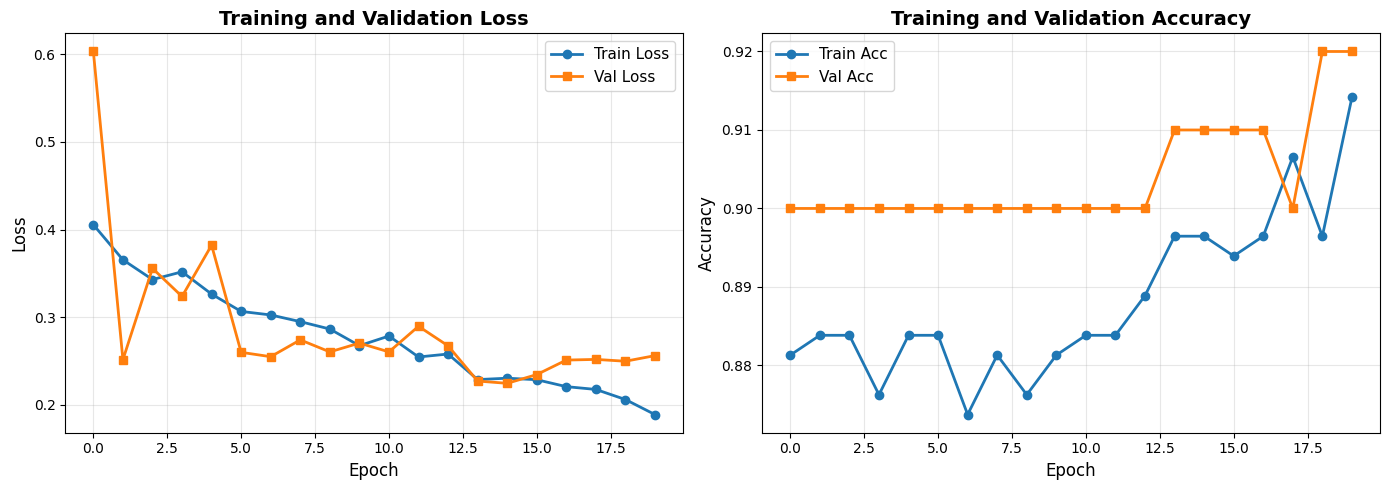

In [56]:
# Plot loss and accuracy curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss', marker='o', linewidth=2)
axes[0].plot(history['val_loss'], label='Val Loss', marker='s', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history['train_acc'], label='Train Acc', marker='o', linewidth=2)
axes[1].plot(history['val_acc'], label='Val Acc', marker='s', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 12. Final Evaluation & Metrics

In [57]:
# Compute final metrics on validation set
val_loss, val_acc, val_preds, val_labels, val_probs = evaluate(
    model, val_loader, criterion, DEVICE
)

print(f"Final Validation Results:")
print(f"  Loss: {val_loss:.4f}")
print(f"  Accuracy: {val_acc:.4f}")

Validation: 100%|██████████| 13/13 [00:05<00:00,  2.45it/s, loss=0.0083, acc=0.920]

Final Validation Results:
  Loss: 0.2497
  Accuracy: 0.9200


In [58]:
# Classification report
print("\nClassification Report:")
print(classification_report(
    val_labels, val_preds, 
    target_names=['Low Grade (0)', 'High Grade (1)'],
    digits=4
))


Classification Report:
                precision    recall  f1-score   support

 Low Grade (0)     1.0000    0.2000    0.3333        10
High Grade (1)     0.9184    1.0000    0.9574        90

      accuracy                         0.9200       100
     macro avg     0.9592    0.6000    0.6454       100
  weighted avg     0.9265    0.9200    0.8950       100



In [59]:
# Confusion matrix
cm = confusion_matrix(val_labels, val_preds)
print("\nConfusion Matrix:")
print(cm)
print(f"\n  True Negatives (Low correctly predicted): {cm[0,0]}")
print(f"  False Positives (Low predicted as High): {cm[0,1]}")
print(f"  False Negatives (High predicted as Low): {cm[1,0]}")
print(f"  True Positives (High correctly predicted): {cm[1,1]}")


Confusion Matrix:
[[ 2  8]
 [ 0 90]]

  True Negatives (Low correctly predicted): 2
  False Positives (Low predicted as High): 8
  False Negatives (High predicted as Low): 0
  True Positives (High correctly predicted): 90


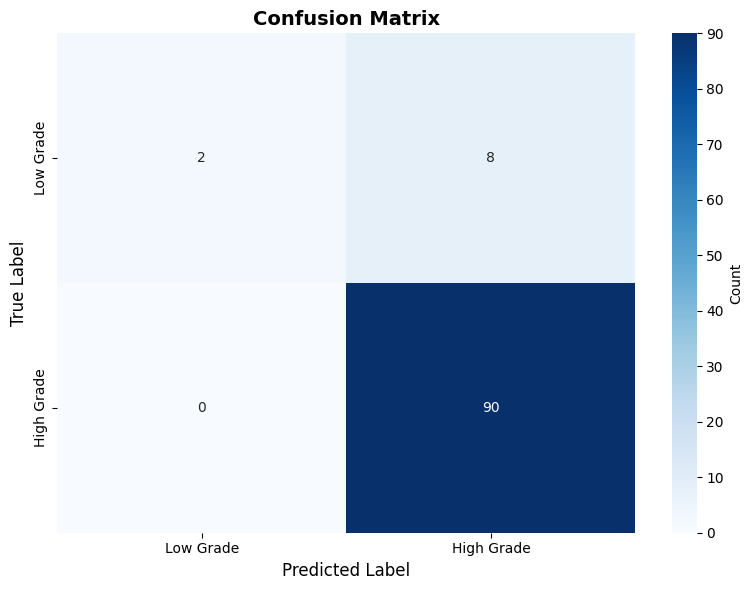

In [60]:
# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=['Low Grade', 'High Grade'],
    yticklabels=['Low Grade', 'High Grade'],
    cbar_kws={'label': 'Count'}
)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 13. Sample Predictions Visualization

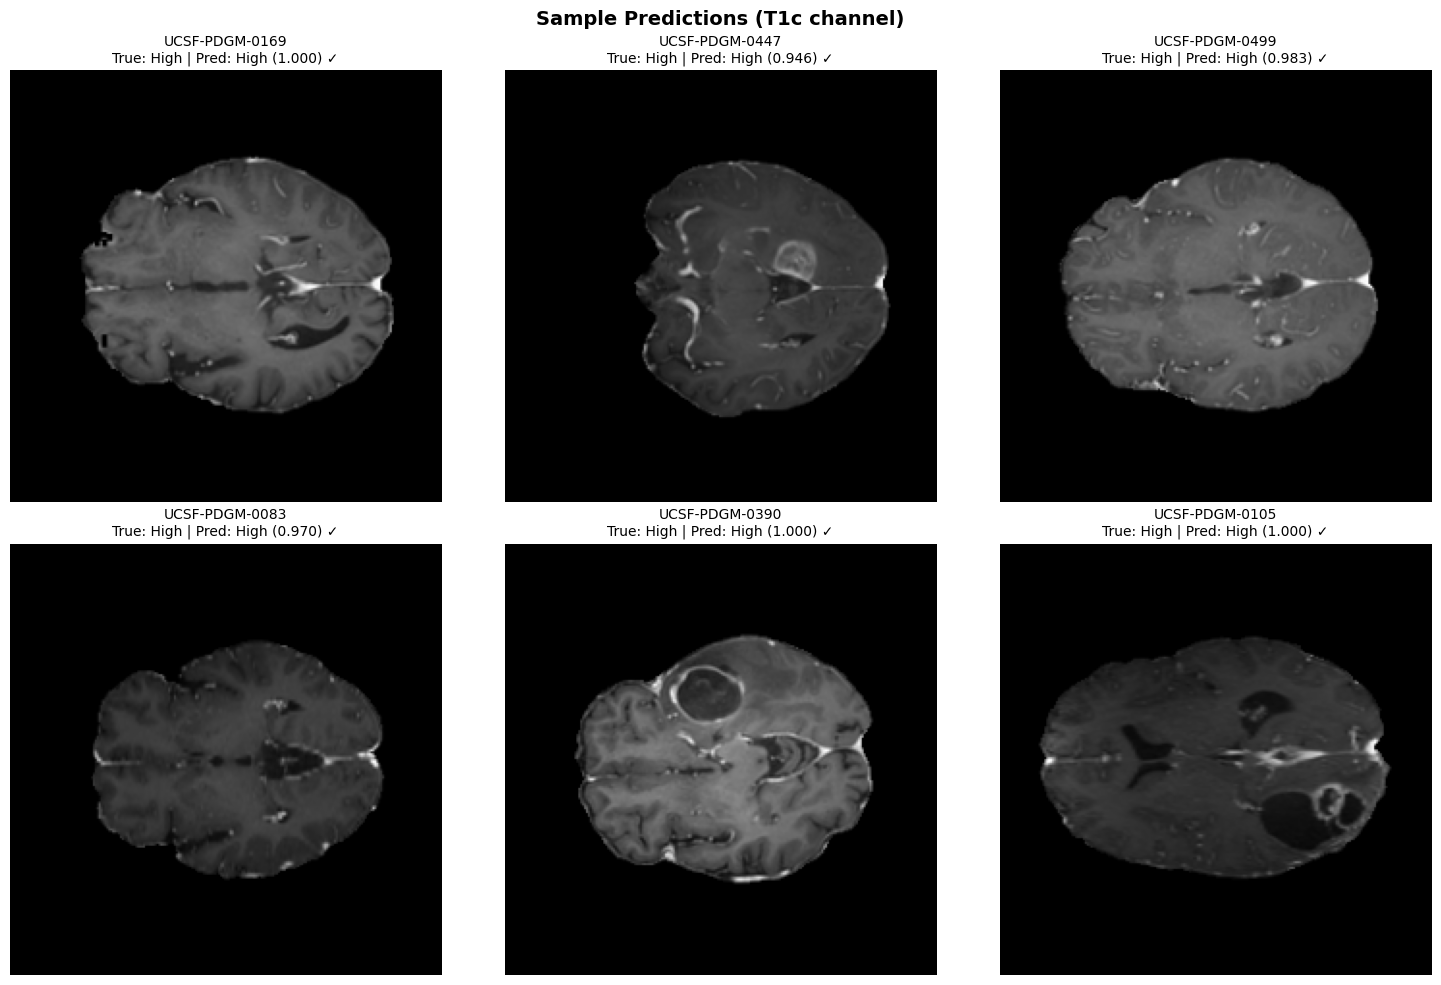

In [61]:
# Visualize predictions on sample cases
n_samples = min(6, len(val_dataset))
sample_indices = random.sample(range(len(val_dataset)), n_samples)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

model.eval()
with torch.no_grad():
    for idx, sample_idx in enumerate(sample_indices):
        # Get sample
        image, true_label = val_dataset[sample_idx]
        patient_id = val_df.loc[sample_idx, 'patient_id']
        
        # Predict
        image_batch = image.unsqueeze(0).to(DEVICE)
        logit = model(image_batch).squeeze()
        prob = torch.sigmoid(logit).item()
        pred_label = 1 if prob >= 0.5 else 0
        
        # Visualize T1c channel (index 1)
        t1c_slice = image[1].cpu().numpy()
        
        # Normalize for display
        t1c_display = t1c_slice - t1c_slice.min()
        if t1c_display.max() > 0:
            t1c_display = t1c_display / t1c_display.max()
        
        # Plot
        ax = axes[idx]
        ax.imshow(t1c_display, cmap='gray')
        
        # Title with prediction info
        true_str = 'High' if true_label == 1 else 'Low'
        pred_str = 'High' if pred_label == 1 else 'Low'
        correct = '✓' if pred_label == int(true_label) else '✗'
        
        ax.set_title(
            f'{patient_id}\n'
            f'True: {true_str} | Pred: {pred_str} ({prob:.3f}) {correct}',
            fontsize=10
        )
        ax.axis('off')

plt.suptitle('Sample Predictions (T1c channel)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 14. Save Model & Results

In [62]:
# Save trained model
MODEL_SAVE_PATH = "resnet18_baseline_best.pth"

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'best_val_acc': best_val_acc,
    'history': history,
    'config': {
        'img_size': IMG_SIZE,
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'num_epochs': NUM_EPOCHS,
        'random_seed': RANDOM_SEED,
        'modalities': MODALITIES
    }
}, MODEL_SAVE_PATH)

print(f"Model saved to: {MODEL_SAVE_PATH}")

Model saved to: resnet18_baseline_best.pth


In [63]:
# Save training history
history_df = pd.DataFrame(history)
history_df.to_csv('training_history.csv', index=False)
print("Training history saved to: training_history.csv")

Training history saved to: training_history.csv


In [64]:
# Save predictions
results_df = pd.DataFrame({
    'patient_id': val_df['patient_id'],
    'true_label': val_labels,
    'predicted_label': val_preds,
    'probability': val_probs
})
results_df.to_csv('validation_predictions.csv', index=False)
print("Validation predictions saved to: validation_predictions.csv")

Validation predictions saved to: validation_predictions.csv
